# Import Packages

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import utils
from sklearn.metrics import mean_squared_error
import numpy as np
from isoweek import Week
import math
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import pickle
import matplotlib.pyplot as plt


# Settings

In [2]:
path_models = utils.get_project_root() + '/Forecasting - Benchmark/models/'

forecast_horizon = 1

# Import Sales Data

In [3]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year <= 2019 OR (Year = 2020 AND Week <= 47) order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:01:53.508301
Mem. usage decreased to 545.14 Mb (13.0% reduction)


In [4]:
# Concatenate Week and Year to simplify code implementation
df_raw.loc[:, 'Date'] = df_raw.Year.astype(str) +'W' +df_raw.Week.astype(str)

In [5]:
df = df_raw.copy()
df

,Week,Year,Site_ID,SKU,Sales_QTY,Season_Year,Vendor_ID,Vendor_Name,Article_Desc,Price_Level,...,Warengruppe_Desc,Subclass_Desc,Class_Desc,Web_Article,Web_Article_From,Web_Article_To,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3,Date
0,26,2010,101,2069466,1.0,9999,0000194449,Hanro AG,HANRO SLIP 3501 S WEISS,obere Preislage,...,Wäsche/Bade,Initial,Slip,X,2014-02-10,2020-11-17,Herren,Wasche/Pyjamas,slip,2010W26
1,27,2010,101,2069466,0.0,9999,0000194449,Hanro AG,HANRO SLIP 3501 S WEISS,obere Preislage,...,Wäsche/Bade,Initial,Slip,X,2014-02-10,2020-11-17,Herren,Wasche/Pyjamas,slip,2010W27
2,28,2010,101,2069466,1.0,9999,0000194449,Hanro AG,HANRO SLIP 3501 S WEISS,obere Preislage,...,Wäsche/Bade,Initial,Slip,X,2014-02-10,2020-11-17,Herren,Wasche/Pyjamas,slip,2010W28
3,29,2010,101,2069466,6.0,9999,0000194449,Hanro AG,HANRO SLIP 3501 S WEISS,obere Preislage,...,Wäsche/Bade,Initial,Slip,X,2014-02-10,2020-11-17,Herren,Wasche/Pyjamas,slip,2010W29
4,30,2010,101,2069466,0.0,9999,0000194449,Hanro AG,HANRO SLIP 3501 S WEISS,obere Preislage,...,Wäsche/Bade,Initial,Slip,X,2014-02-10,2020-11-17,Herren,Wasche/Pyjamas,slip,2010W30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158140,47,2020,102,1288695802,1.0,9999,0000946191,Calvin Klein Europe BV,"CK Low Ris Trunk 2P Micro NB, schwarz, M",mittlere Preislage,...,Wäsche/Bade,Initial,Boxershorts,X,2020-10-08,9999-12-31,Herren,Wasche/Pyjamas,shortsimdoppelpack,2020W47
3158141,47,2020,115,1288695802,2.0,9999,0000946191,Calvin Klein Europe BV,"CK Low Ris Trunk 2P Micro NB, schwarz, M",mittlere Preislage,...,Wäsche/Bade,Initial,Boxershorts,X,2020-10-08,9999-12-31,Herren,Wasche/Pyjamas,shortsimdoppelpack,2020W47
3158142,47,2020,103,1288743328,1.0,2021,0000941918,RALPH LAUREN GERMANY GMBH,"M_PRL PULLOVER 710680593, grau mittel, L",obere Preislage,...,Casual-Marken O,Initial,Strick LA,X,2020-11-30,9999-12-31,Herren,Pullover&Strick,strickpullover,2020W47
3158143,47,2020,101,1289250705,1.0,9999,0000948574,Santoni S.P.A.,"NOS_SANTONI SCHUHSPANNER UFAA, nature, 9",obere Preislage,...,Herrenschuhe,Schuhzubehör,Furnituren,X,2020-10-29,9999-12-31,Damen Accessoires,Schuhpflege,schuhzubehoer,2020W47


# Data Preprocessing

In [6]:
# keep only relevant columns
df = df[['Week', 'Year', 'Site_ID', 'SKU', 'Sales_QTY', 'Season_Year',
       'Vendor_ID','Price_Level','Web_Article','CENSHARE_CAT_1', 'CENSHARE_CAT_2', 'CENSHARE_CAT_3']].copy()

In [7]:
# Get rid of negative Sales
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)

In [8]:
# Convert categorical features to integers 
df = utils.encode_categorical(df, ['Site_ID', 'SKU','Season_Year','Vendor_ID','Web_Article','Price_Level', 'CENSHARE_CAT_1',
       'CENSHARE_CAT_2', 'CENSHARE_CAT_3'], downcast_cols=False)

# Feature Engineering

In [9]:
df['rolling_mean_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])['Sales_QTY'].transform(lambda x: x.shift(1).rolling(window=4).mean())

df['rolling_mean_w8'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])['Sales_QTY'].transform(lambda x: x.shift(1).rolling(window=8).mean())

df['lag_w1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])['Sales_QTY'].transform(lambda x: x.shift(1))

df['lag_w2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])['Sales_QTY'].transform(lambda x: x.shift(2))

df['lag_w3'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])['Sales_QTY'].transform(lambda x: x.shift(3))

df['lag_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])['Sales_QTY'].transform(lambda x: x.shift(4))

df['lag_y1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])['Sales_QTY'].transform(lambda x: x.shift(52))

df['lag_y2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])['Sales_QTY'].transform(lambda x: x.shift(104))


In [10]:
df

,Week,Year,Site_ID,SKU,Sales_QTY,Season_Year,Vendor_ID,Price_Level,Web_Article,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3,rolling_mean_w4,rolling_mean_w8,lag_w1,lag_w2,lag_w3,lag_w4,lag_y1,lag_y2
0,26,2010,0,0,1.0,6,14,4,1,2,25,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27,2010,0,0,0.0,6,14,4,1,2,25,84,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,28,2010,0,0,1.0,6,14,4,1,2,25,84,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
3,29,2010,0,0,6.0,6,14,4,1,2,25,84,NaN,NaN,1.0,0.0,1.0,NaN,NaN,NaN
4,30,2010,0,0,0.0,6,14,4,1,2,25,84,2.0,NaN,6.0,1.0,0.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158140,47,2020,1,5338,1.0,6,49,3,1,2,25,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3158141,47,2020,5,5338,2.0,6,49,3,1,2,25,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3158142,47,2020,2,5339,1.0,5,24,4,1,2,14,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3158143,47,2020,0,5340,1.0,6,86,4,1,1,18,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  Forecasting

In [11]:
cat_features = [
'Week', 'Year', 'Site_ID', 'SKU','Season_Year',
       'Vendor_ID', 'Price_Level', 'Web_Article', 'CENSHARE_CAT_1',
       'CENSHARE_CAT_2', 'CENSHARE_CAT_3'
]

num_features = [
'rolling_mean_w4', 'lag_w1',
       'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1', 'lag_y2'
]

features = cat_features + num_features

In [12]:
splits = utils.get_splits(df, fh=forecast_horizon, n_splits=5)

In [13]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [14]:
rmse = []

for week, year in splits:
    print(f'\n\n****** {year}W{week} ******')
    
    evals_result = {}
    
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][features]
    y_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])].Sales_QTY

    x_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][features]
    y_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]].Sales_QTY
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
    
    
    print('log: save model and evals result')
    gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))




****** 2020W46 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4443
[LightGBM] [Info] Number of data points in the train set: 3132349, number of used features: 18
[LightGBM] [Info] Start training from score -1.679006
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.729748	valid_1's rmse: 0.33076
[50]	training's rmse: 0.718712	valid_1's rmse: 0.325885
[75]	training's rmse: 0.714484	valid_1's rmse: 0.323932
[100]	training's rmse: 0.708338	valid_1's rmse: 0.322913
[125]	training's rmse: 0.70518	valid_1's rmse: 0.322282
[150]	training's rmse: 0.702403	valid_1's rmse: 0.321872
[175]	training's rmse: 0.699406	valid_1's rmse: 0.321357
[200]	training's rmse: 0.697426	valid_1's rmse: 0.32118
[225]	training's rmse: 0.69586	valid_1's rmse: 0.320992
[250]	training's rmse: 0.694626	valid_1's rmse: 0.320826
[275]	training's rmse: 0.693284	valid_1's rmse: 0.320555
[300]	training's rmse: 0.69188	valid_1's rmse: 0.320446
[325]	training's rmse: 0.690952	valid_1's rmse: 0.320319
Early stopping, best iteration is:
[324]	training's rmse: 0.69096	valid_1's rmse: 0.320315
log: save model and evals result


****** 2020W45 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4394
[LightGBM] [Info] Number of data points in the train set: 3106744, number of used features: 18
[LightGBM] [Info] Start training from score -1.674022
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.732321	valid_1's rmse: 0.367434
[50]	training's rmse: 0.724019	valid_1's rmse: 0.363889
[75]	training's rmse: 0.717497	valid_1's rmse: 0.361101
[100]	training's rmse: 0.7121	valid_1's rmse: 0.359806
[125]	training's rmse: 0.70741	valid_1's rmse: 0.35912
[150]	training's rmse: 0.704136	valid_1's rmse: 0.358831
[175]	training's rmse: 0.70255	valid_1's rmse: 0.358371
[200]	training's rmse: 0.70078	valid_1's rmse: 0.35783
[225]	training's rmse: 0.699101	valid_1's rmse: 0.357468
[250]	training's rmse: 0.697275	valid_1's rmse: 0.357079
[275]	training's rmse: 0.69594	valid_1's rmse: 0.357053
Early stopping, best iteration is:
[255]	training's rmse: 0.696702	valid_1's rmse: 0.357041
log: save model and evals result


****** 2020W44 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4344
[LightGBM] [Info] Number of data points in the train set: 3081356, number of used features: 18
[LightGBM] [Info] Start training from score -1.668632
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.734205	valid_1's rmse: 0.406558
[50]	training's rmse: 0.724067	valid_1's rmse: 0.401442
[75]	training's rmse: 0.719545	valid_1's rmse: 0.399938
[100]	training's rmse: 0.712334	valid_1's rmse: 0.398809
[125]	training's rmse: 0.709407	valid_1's rmse: 0.398293
[150]	training's rmse: 0.706021	valid_1's rmse: 0.398046
[175]	training's rmse: 0.703752	valid_1's rmse: 0.397769
[200]	training's rmse: 0.702402	valid_1's rmse: 0.39753
[225]	training's rmse: 0.700372	valid_1's rmse: 0.397433
[250]	training's rmse: 0.698687	valid_1's rmse: 0.397379
[275]	training's rmse: 0.697919	valid_1's rmse: 0.397314
[300]	training's rmse: 0.696988	valid_1's rmse: 0.397239
[325]	training's rmse: 0.696268	valid_1's rmse: 0.397224
[350]	training's rmse: 0.694845	valid_1's rmse: 0.397222
Early stopping, best iteration is:
[333]	training's rmse: 0.696018	valid_1's rmse: 0.397161
log: save model and evals result


****** 2020W43 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4304
[LightGBM] [Info] Number of data points in the train set: 3056156, number of used features: 18
[LightGBM] [Info] Start training from score -1.663597
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.736039	valid_1's rmse: 0.412615
[50]	training's rmse: 0.726143	valid_1's rmse: 0.408075
[75]	training's rmse: 0.721433	valid_1's rmse: 0.405837
[100]	training's rmse: 0.71453	valid_1's rmse: 0.404474
[125]	training's rmse: 0.711515	valid_1's rmse: 0.403763
[150]	training's rmse: 0.708414	valid_1's rmse: 0.402957
[175]	training's rmse: 0.70538	valid_1's rmse: 0.402401
[200]	training's rmse: 0.704156	valid_1's rmse: 0.402118
[225]	training's rmse: 0.702714	valid_1's rmse: 0.401823
[250]	training's rmse: 0.701197	valid_1's rmse: 0.401523
[275]	training's rmse: 0.699654	valid_1's rmse: 0.401234
[300]	training's rmse: 0.698344	valid_1's rmse: 0.401132
[325]	training's rmse: 0.697124	valid_1's rmse: 0.400851
[350]	training's rmse: 0.696567	valid_1's rmse: 0.400777
[375]	training's rmse: 0.69588	valid_1's rmse: 0.400669
[400]	training's rmse: 0.694814	valid_1's rmse: 0.400441
[425]	training's rmse: 0.693809	valid_1's rmse: 0.40028
[450]	training's rmse: 0.692577	valid_

c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4255
[LightGBM] [Info] Number of data points in the train set: 3031163, number of used features: 18
[LightGBM] [Info] Start training from score -1.657993
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.738642	valid_1's rmse: 0.323647
[50]	training's rmse: 0.728705	valid_1's rmse: 0.31893
[75]	training's rmse: 0.723621	valid_1's rmse: 0.316217
[100]	training's rmse: 0.718426	valid_1's rmse: 0.31549
[125]	training's rmse: 0.714075	valid_1's rmse: 0.31487
[150]	training's rmse: 0.710713	valid_1's rmse: 0.314611
[175]	training's rmse: 0.708142	valid_1's rmse: 0.313797
[200]	training's rmse: 0.70693	valid_1's rmse: 0.313515
[225]	training's rmse: 0.70479	valid_1's rmse: 0.313091
[250]	training's rmse: 0.703158	valid_1's rmse: 0.31307
[275]	training's rmse: 0.70232	valid_1's rmse: 0.312783
[300]	training's rmse: 0.700941	valid_1's rmse: 0.312675
[325]	training's rmse: 0.700473	valid_1's rmse: 0.312549
[350]	training's rmse: 0.698965	valid_1's rmse: 0.312218
[375]	training's rmse: 0.697939	valid_1's rmse: 0.312125
[400]	training's rmse: 0.69683	valid_1's rmse: 0.311985
[425]	training's rmse: 0.696285	valid_1's rmse: 0.31114
[450]	training's rmse: 0.695299	valid_1's r

In [15]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [0.32031454494214584, 0.3570406702889443, 0.39716065595658706, 0.39959679661955455, 0.3108721191242687]

Crossvalidated RMSE:  0.3569969573863001


****** 2020W46 ******


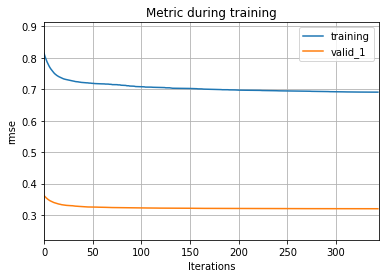

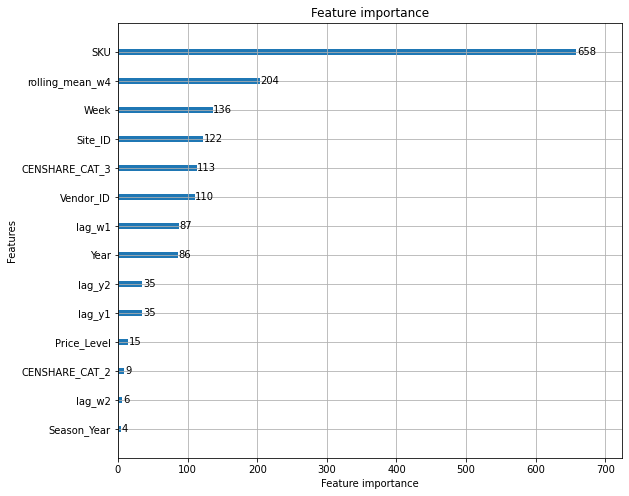

****** 2020W45 ******


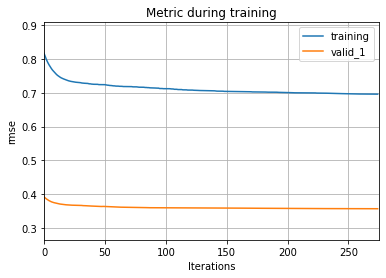

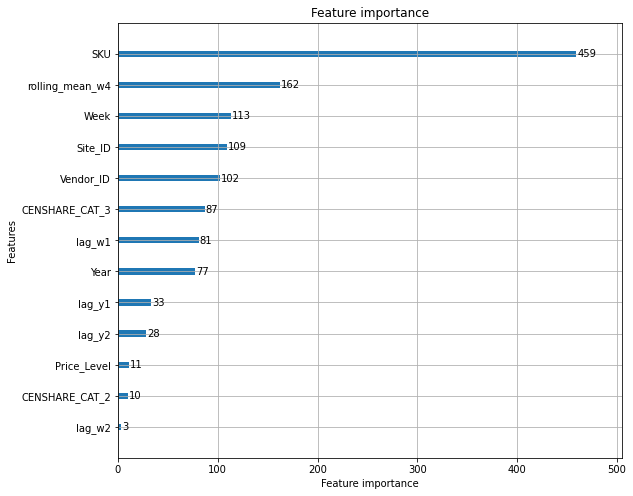

****** 2020W44 ******


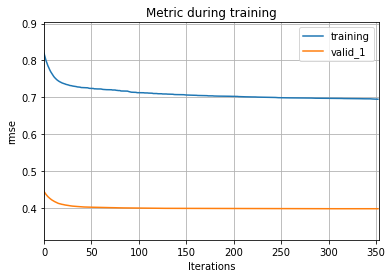

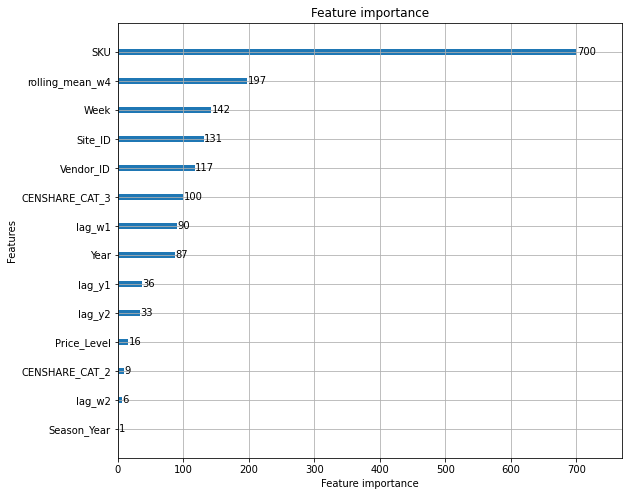

****** 2020W43 ******


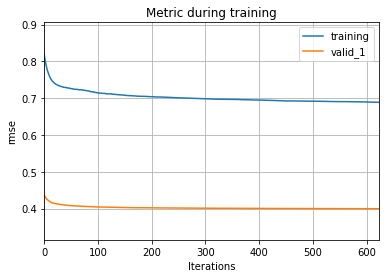

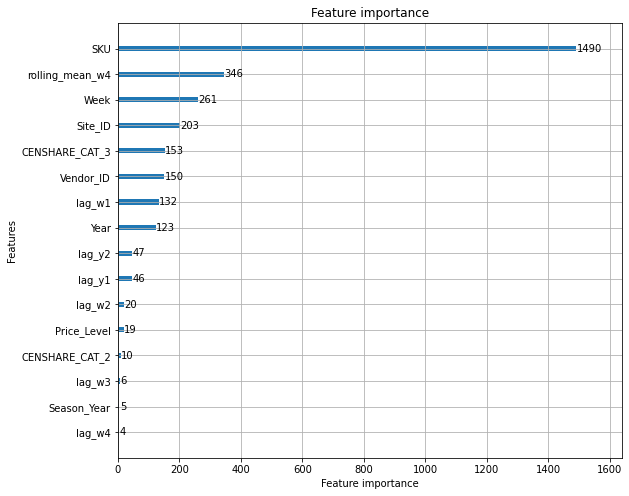

****** 2020W42 ******


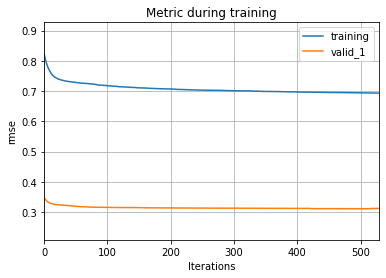

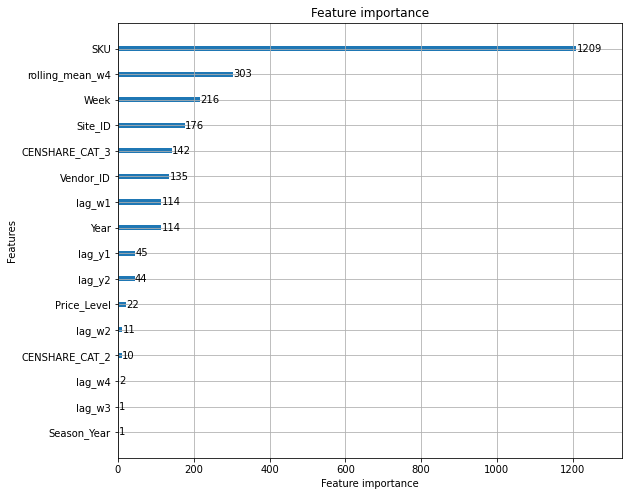

In [16]:
for week, year in splits:
    print(f'****** {year}W{week} ******')
    
    mod = lgb.Booster(model_file=path_models + f'gbm_{year}w{week}.txt')
    evals = pickle.load(open(path_models + f'evals_result_{year}w{week}.pkl', 'rb'))

    ax = lgb.plot_metric(evals)
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(10,8))
    plt.gcf().subplots_adjust(left=0.2)
    plt.show()
    

# Compute Min Stock for next Week

In [17]:
for week, year in [splits[0]]:
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][features]
    y_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])].Sales_QTY

    x_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][features]
    y_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]].Sales_QTY
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4443
[LightGBM] [Info] Number of data points in the train set: 3132349, number of used features: 18
[LightGBM] [Info] Start training from score -1.679006
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.729748	valid_1's rmse: 0.33076
[50]	training's rmse: 0.718712	valid_1's rmse: 0.325885
[75]	training's rmse: 0.714484	valid_1's rmse: 0.323932
[100]	training's rmse: 0.708338	valid_1's rmse: 0.322913
[125]	training's rmse: 0.70518	valid_1's rmse: 0.322282
[150]	training's rmse: 0.702403	valid_1's rmse: 0.321872
[175]	training's rmse: 0.699406	valid_1's rmse: 0.321357
[200]	training's rmse: 0.697426	valid_1's rmse: 0.32118
[225]	training's rmse: 0.69586	valid_1's rmse: 0.320992
[250]	training's rmse: 0.694626	valid_1's rmse: 0.320826
[275]	training's rmse: 0.693284	valid_1's rmse: 0.320555
[300]	training's rmse: 0.69188	valid_1's rmse: 0.320446
[325]	training's rmse: 0.690952	valid_1's rmse: 0.320319
Early stopping, best iteration is:
[324]	training's rmse: 0.69096	valid_1's rmse: 0.320315


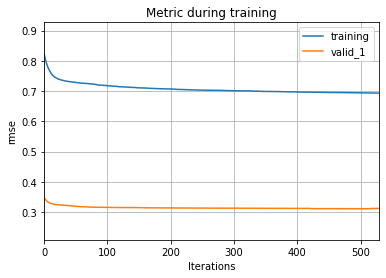

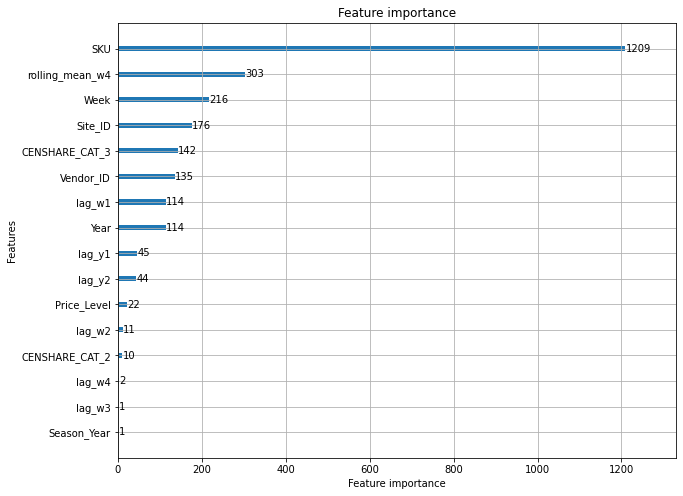

In [18]:
ax = lgb.plot_metric(evals)
plt.show()

ax = lgb.plot_importance(mod, figsize=(10,8))

In [19]:
relevant_columns = ['Week','Year','Site_ID','SKU','Forecast','Min Stock','Target (True Sales QTY)','Prediction Error','Article_Desc','Mainsector_ID','Mainsector_Desc','Warengruppe_ID', 'Warengruppe_Desc','Vendor_ID', 'Vendor_Name']
stock = df_raw.loc[df_raw.Year == (Week(year, week)+1)[0]].loc[df_raw.Week == (Week(year, week)+1)[1]].copy()
stock.loc[:, 'Forecast'] = np.round(y_pred,2)
stock.loc[:, 'Min Stock'] = np.ceil(stock['Forecast'] * 2).clip(lower=1)
stock.loc[:, 'Target (True Sales QTY)'] = y_test.to_list()
stock.loc[:, 'Prediction Error'] = np.round(abs(y_pred - y_test.to_list()) ,2)
stock = stock.loc[:,relevant_columns]
stock = stock.rename(columns={'SKU': 'Article_ID'})
stock = stock.sort_values(by=['Min Stock', 'Forecast'], ascending=False)
stock.to_csv('Wareverschiebung-VZ-zu-Filiale.csv', index=False, encoding='utf-8')
stock

,Week,Year,Site_ID,Article_ID,Forecast,Min Stock,Target (True Sales QTY),Prediction Error,Article_Desc,Mainsector_ID,Mainsector_Desc,Warengruppe_ID,Warengruppe_Desc,Vendor_ID,Vendor_Name
241805,47,2020,590,13741603,5.58,12.0,2.0,3.58,SOCKEN 10-024/1BASIS 41/42 09 SCHWARZ,20,Herren-Mode,566,Socken,0000124354,Jacob Rohner AG
239844,47,2020,107,13741603,3.37,7.0,3.0,0.37,SOCKEN 10-024/1BASIS 41/42 09 SCHWARZ,20,Herren-Mode,566,Socken,0000124354,Jacob Rohner AG
940935,47,2020,101,1021984505,2.55,6.0,0.0,2.55,"SOCKEN 2ER PACK 371111 C, schwarz, 39-42",20,Herren-Mode,566,Socken,0000945636,stichd bv
943812,47,2020,590,1021984505,2.55,6.0,12.0,9.45,"SOCKEN 2ER PACK 371111 C, schwarz, 39-42",20,Herren-Mode,566,Socken,0000945636,stichd bv
244217,47,2020,107,13741629,2.53,6.0,0.0,2.53,SOCKEN 10-024/1BASIS 43/44 09 SCHWARZ,20,Herren-Mode,566,Socken,0000124354,Jacob Rohner AG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2644398,47,2020,106,1261409508,0.01,1.0,0.0,0.01,"34.20 ROYR Cast Derby Midcu, schwarz, 41",20,Herren-Mode,570,Herrenschuhe,0000946076,Royal Republiq
2644893,47,2020,106,1261409509,0.01,1.0,0.0,0.01,"34.20 ROYR Cast Derby Midcu, schwarz, 42",20,Herren-Mode,570,Herrenschuhe,0000946076,Royal Republiq
2646206,47,2020,106,1261409511,0.01,1.0,0.0,0.01,"34.20 ROYR Cast Derby Midcu, schwarz, 44",20,Herren-Mode,570,Herrenschuhe,0000946076,Royal Republiq
2849082,47,2020,106,1268911623,0.01,1.0,0.0,0.01,"NB 24.32 DL alt Business Der, cognac, 41",20,Herren-Mode,570,Herrenschuhe,0000946980,Navyboot AG


In [20]:
# Analyse the greatest Errors
stock.sort_values(by=['Prediction Error'], ascending=False).head(25)

,Week,Year,Site_ID,Article_ID,Forecast,Min Stock,Target (True Sales QTY),Prediction Error,Article_Desc,Mainsector_ID,Mainsector_Desc,Warengruppe_ID,Warengruppe_Desc,Vendor_ID,Vendor_Name
947141,47,2020,590,1021984506,1.86,4.0,13.0,11.14,"SOCKEN 2ER PACK 371111 C, schwarz, 43-46",20,Herren-Mode,566,Socken,0000945636,stichd bv
943812,47,2020,590,1021984505,2.55,6.0,12.0,9.45,"SOCKEN 2ER PACK 371111 C, schwarz, 39-42",20,Herren-Mode,566,Socken,0000945636,stichd bv
210164,47,2020,102,13741205,0.67,2.0,10.0,9.33,SOCKEN 10-064/1 BASI 41/42 09 SCHWARZ,20,Herren-Mode,566,Socken,0000124354,Jacob Rohner AG
2764190,47,2020,101,1261745607,0.44,1.0,9.0,8.56,"Zim_Boxer Business Class 222, schwarz, M",20,Herren-Mode,567,Wäsche/Bade,0000185793,Zimmerli Textil AG
1889110,47,2020,101,1176185807,0.16,1.0,7.0,6.84,"BOXER 172-1464 PURE COMFORT, schwarz, L",20,Herren-Mode,567,Wäsche/Bade,0000185793,Zimmerli Textil AG
542266,47,2020,590,31158266,0.35,1.0,7.0,6.65,PANT UNI M SCHWARZ,20,Herren-Mode,567,Wäsche/Bade,0000194449,Hanro AG
2764849,47,2020,590,1261745607,0.09,1.0,6.0,5.91,"Zim_Boxer Business Class 222, schwarz, M",20,Herren-Mode,567,Wäsche/Bade,0000185793,Zimmerli Textil AG
3157102,47,2020,103,1286631503,0.22,1.0,6.0,5.78,"T-SHIRT DUOPACK VN 47657, weiss, M",20,Herren-Mode,567,Wäsche/Bade,0000942615,RAGMAN TEXTILHANDEL GMBH
930532,47,2020,590,1021984501,0.79,2.0,6.0,5.21,"SOCKEN 2ER PACK 371111 CLAS, navy, 39-42",20,Herren-Mode,566,Socken,0000945636,stichd bv
272286,47,2020,107,14292102,1.15,3.0,6.0,4.85,SOCKEN 10-064/1 BASI 43/44 213 MARENGO,20,Herren-Mode,566,Socken,0000124354,Jacob Rohner AG
